In [23]:
import ee
import geemap
import json
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

ee.Authenticate()
ee.Initialize(project='ee-yuxinchen118')

In [24]:
# 定义上海研究区域 - 缩小范围以提高计算效率
center_lat = 31.3304
center_lon = 121.5737

# 保持原来的研究区域范围（40x50km）
km_to_deg_lat = 1 / 111.32
km_to_deg_lon = 1 / (111.32 * math.cos(math.radians(center_lat)))

lat_extent = 40 * km_to_deg_lat  # 保持原始范围
lon_extent = 50 * km_to_deg_lon  # 保持原始范围

shanghai_region = ee.Geometry.Rectangle([
    center_lon - lon_extent / 2,
    center_lat - lat_extent / 2,
    center_lon + lon_extent / 2,
    center_lat + lat_extent / 2
])

# 类别映射
desired_order = [0, 1, 4, 6, 7]
value_to_new_class = {original: i for i, original in enumerate(desired_order)}

# 加载和处理CSV数据
df = pd.read_csv('Shanghai_Feature_Collection.csv')
df = df[df['landcover'].isin(desired_order)]
df['class'] = df['landcover'].map(value_to_new_class)

# 限制样本数量但保持每类足够的样本
max_samples_per_class = 1000  # 增加每类样本数量
df_sampled = df.groupby('class').apply(lambda x: x.sample(min(len(x), max_samples_per_class))).reset_index(drop=True)

# 转换为Earth Engine FeatureCollection
features = []
for _, row in df_sampled.iterrows():
    try:
        geom = json.loads(row['.geo'])
        ee_geom = ee.Geometry(geom)
        cls = int(row['class'])
        features.append(ee.Feature(ee_geom, {'class': cls}))
    except:
        continue

polygon_fc = ee.FeatureCollection(features)



In [25]:
# 加载Sentinel-2影像
image_id = "20220227T023639_20220227T024821_T51RUQ"
sentinel_image = ee.Image("COPERNICUS/S2_SR/" + image_id)

# 选择关键波段
selected_bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'] 
image = sentinel_image.select(selected_bands).clip(shanghai_region)

ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
ndbi = image.normalizedDifference(['B11', 'B8']).rename('NDBI')
bsi = image.expression(
    '((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2))', {
        'B11': image.select('B11'),
        'B4': image.select('B4'),
        'B8': image.select('B8'),
        'B2': image.select('B2')
    }
).rename('BSI')

composite = image.addBands([ndvi, ndwi, ndbi, bsi])
all_bands = selected_bands + ['NDVI', 'NDWI', 'NDBI', 'BSI']

print("准备训练数据...")

# 从polygon中采样像素（优化参数以处理大区域）
sampled_pixels = composite.sampleRegions(
    collection=polygon_fc,
    properties=['class'],
    scale=10,  # 保持10m分辨率
    geometries=True ,
    tileScale=8  # 增加tileScale以处理大区域
)

# 每个类别固定使用1000个训练样本（无论原始样本量多少）
training_pixels = ee.FeatureCollection([])
for i in range(5):
    class_pixels = sampled_pixels.filter(ee.Filter.eq('class', i)).limit(1000)  # 每类固定1000个像素
    training_pixels = training_pixels.merge(class_pixels)

# 输出样本数量
for i in range(5):
    count = training_pixels.filter(ee.Filter.eq('class', i)).size().getInfo()
    print(f"Class {i} pixel samples: {count}")

# 分割训练和验证数据 (7:3比例)
with_random = training_pixels.randomColumn('random', 42)
train_data = with_random.filter(ee.Filter.lt('random', 0.7))
val_data = with_random.filter(ee.Filter.gte('random', 0.7))

print("Training pixels:", train_data.size().getInfo())  
print("Validation pixels:", val_data.size().getInfo()) 


准备训练数据...
Class 0 pixel samples: 1000
Class 1 pixel samples: 1000
Class 2 pixel samples: 1000
Class 3 pixel samples: 1000
Class 4 pixel samples: 1000
Training pixels: 3484
Validation pixels: 1516


In [26]:
print("\n开始导出CSV文件...")

# 导出训练数据为CSV
train_export_task = ee.batch.Export.table.toDrive(
    collection=train_data,
    description='SH_pixels_training_data',
    fileNamePrefix='SH_pixels_training_data',
    fileFormat='CSV',
    folder='EarthEngine_Exports'  # Google Drive中的文件夹名称，可以修改
)

# 导出验证数据为CSV
val_export_task = ee.batch.Export.table.toDrive(
    collection=val_data,
    description='SH_pixels_validation_data',
    fileNamePrefix='SH_pixels_validation_data',
    fileFormat='CSV',
    folder='EarthEngine_Exports'  # Google Drive中的文件夹名称，可以修改
)

# 启动导出任务
print("启动训练数据导出任务...")
train_export_task.start()

print("启动验证数据导出任务...")
val_export_task.start()

print("导出任务已启动！")
print("请到您的Google Drive查看导出进度和结果文件。")
print("文件将保存在 'EarthEngine_Exports' 文件夹中。")


开始导出CSV文件...
启动训练数据导出任务...
启动验证数据导出任务...
导出任务已启动！
请到您的Google Drive查看导出进度和结果文件。
文件将保存在 'EarthEngine_Exports' 文件夹中。


In [40]:
# 读取训练和验证 CSV
train_df = pd.read_csv('SH_pixels_training_data.csv')
valid_df = pd.read_csv('SH_pixels_validation_data.csv')

# 提取波段名
all_bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7',
             'B8', 'B8A', 'B11', 'B12',
             'NDVI', 'NDWI', 'NDBI', 'BSI']

# 将 pandas DataFrame 转换为 GEE FeatureCollection
def df_to_fc(df):
    features = []
    for _, row in df.iterrows():
        geom = ee.Geometry.Point(json.loads(row['.geo'])['coordinates'])
        properties = {key: row[key] for key in all_bands + ['class']}
        features.append(ee.Feature(geom, properties))
    return ee.FeatureCollection(features)

train_fc = df_to_fc(train_df)
valid_fc = df_to_fc(valid_df)

In [43]:
# 从 composite 中提取样本用于训练
train_data = composite.sampleRegions(
    collection=train_fc,
    properties=['class'],
    scale=10,
    geometries=False
)

# 训练 Random Forest 分类器
classifier = ee.Classifier.smileRandomForest(
    numberOfTrees=100,
    seed=42,
    minLeafPopulation=10,
    bagFraction=0.7
).train(
    features=train_data,
    classProperty='class',
    inputProperties=all_bands
)

# 应用分类器
classified = composite.classify(classifier)

# 显示分类图层（如果使用 geemap）
import geemap
Map = geemap.Map(center=[31.3, 121.5], zoom=10)
Map.addLayer(classified,
             {'min': 0, 'max': 4, 'palette': ['#419BDF', '#397D49', '#E49635', '#C4281B', '#A59B8F']},
             'RF Classification')
Map

Map(center=[31.3, 121.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

Validation Accuracy: 0.9492084432717678
Confusion Matrix:
[[320   0   0   0   0]
 [  0 273   9  21   0]
 [  0   3 278   6   2]
 [  0   8  10 258  11]
 [  0   0   1   6 310]]


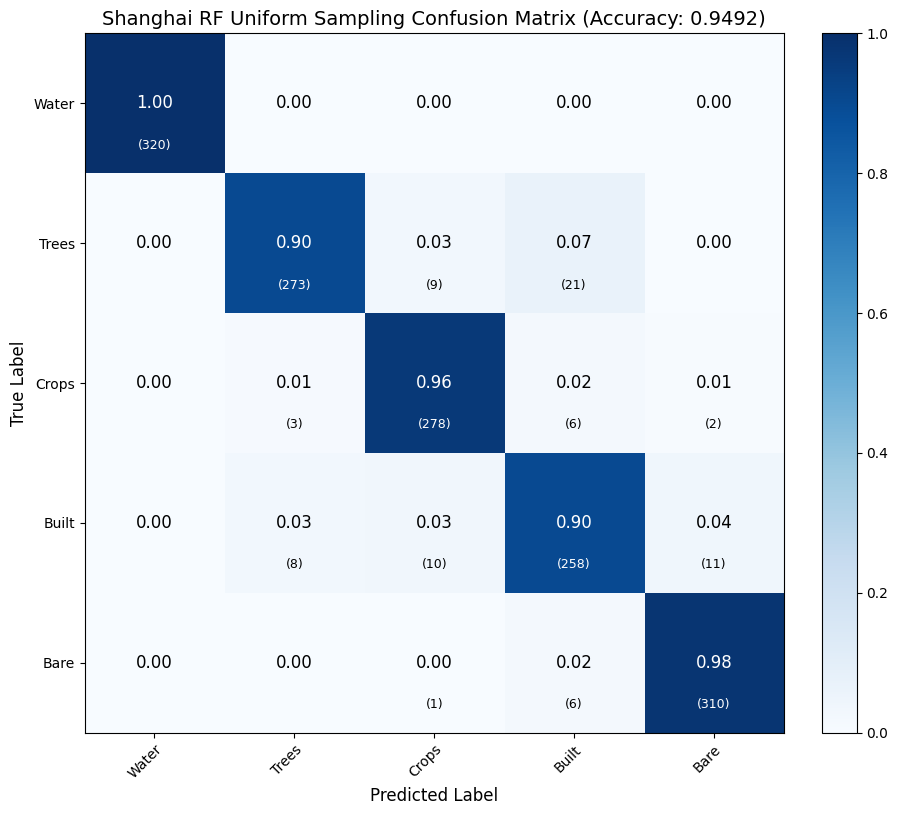

In [44]:
# 从 composite 中提取样本用于验证（注意 geometries=False）
val_data = composite.sampleRegions(
    collection=valid_fc,
    properties=['class'],
    scale=10,
    geometries=False
)

# 用训练好的分类器对验证集进行分类
validated = val_data.classify(classifier)

# 计算混淆矩阵
confusion_matrix = validated.errorMatrix('class', 'classification')

# 输出准确率
print('Validation Accuracy:', confusion_matrix.accuracy().getInfo())
print('Confusion Matrix:')
print(np.array(confusion_matrix.array().getInfo()))

# 可视化混淆矩阵（你的函数）
def plot_ee_confusion_matrix(confusion_matrix, class_names=None):
    cm_array = np.array(confusion_matrix.array().getInfo())
    accuracy = confusion_matrix.accuracy().getInfo()
    if class_names is None:
        n_classes = cm_array.shape[0]
        class_names = [str(i) for i in range(n_classes)]
    cm_normalized = np.zeros(cm_array.shape)
    for i in range(cm_array.shape[0]):
        row_sum = np.sum(cm_array[i, :])
        if row_sum > 0:
            cm_normalized[i, :] = cm_array[i, :] / row_sum
    
    fig, ax = plt.subplots(figsize=(10, 8))

    im = ax.imshow(cm_normalized, interpolation='nearest', cmap='Blues', vmin=0, vmax=1)
    
    ax.set_title(f'Shanghai RF Uniform Sampling Confusion Matrix (Accuracy: {accuracy:.4f})', fontsize=14)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)
   
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, f"{cm_normalized[i, j]:.2f}",
                    ha="center", va="center",
                    color="white" if cm_normalized[i, j] > 0.5 else "black",
                    fontsize=12)
            if cm_array[i, j] > 0:
                ax.text(j, i + 0.3, f"({int(cm_array[i, j])})",
                        ha="center", va="center",
                        color="white" if cm_normalized[i, j] > 0.5 else "black",
                        fontsize=9)
    
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    return fig, ax

# 设置类别名称
class_names = ['Water', 'Trees', 'Crops', 'Built', 'Bare']

# 调用绘图
fig, ax = plot_ee_confusion_matrix(confusion_matrix, class_names)
plt.show()


In [5]:
# Print distribution for each class in train/val sets
n_classes = 5
for class_id in range(n_classes):
    train_count = train_data.filter(ee.Filter.eq('class', class_id)).size().getInfo()
    val_count = val_data.filter(ee.Filter.eq('class', class_id)).size().getInfo()
    print(f"Class {class_id} - Training: {train_count}, Validation: {val_count}")

Class 0 - Training: 690, Validation: 310
Class 1 - Training: 721, Validation: 279


KeyboardInterrupt: 

In [41]:
# 训练随机森林分类器（优化参数以处理更多数据）
print("训练分类器...")
classifier = ee.Classifier.smileRandomForest(
    numberOfTrees=100,  # 增加树的数量以提高精度
    seed=42,
    minLeafPopulation=10,
    bagFraction=0.7
).train(
    features=train_data, 
    classProperty='class', 
    inputProperties=all_bands
)

# 应用分类器
print("应用分类器...")
classified = composite.classify(classifier)




训练分类器...
应用分类器...


In [42]:
# 设置颜色方案
color_scheme = {
    'water': '#419BDF',
    'trees': '#397D49', 
    'crops': '#E49635',
    'built': '#C4281B',
    'bare': '#A59B8F'
}
classes = ['water', 'trees', 'crops', 'built', 'bare']
palette = [color_scheme[c] for c in classes]

# 创建地图显示
print("创建地图...")
Map = geemap.Map()
Map.setCenter(121.57, 31.33, 11)

# 添加图层（使用更小的可视化参数）
Map.addLayer(
    image.select(['B4', 'B3', 'B2']),
    {'min': 0, 'max': 2500}, 
    'True Color'
)

Map.addLayer(
    classified,
    {'min': 0, 'max': 4, 'palette': palette}, 
    'Shanghai Land Cover'
)

# 添加训练样本点
sample_points = ee.Image().paint(polygon_fc, 'class', 2)
Map.addLayer(
    sample_points,
    {'min': 0, 'max': 4, 'palette': palette},
    'Training Samples',
    False  # 默认不显示
)

# 添加图例
Map.add_legend(title="Land Cover Types", legend_dict=color_scheme)

print("地图准备完成!")
Map

创建地图...


EEException: Collection.loadTable: Collection asset 'users/yuxinchen118/SH_pixels_training_data' not found.

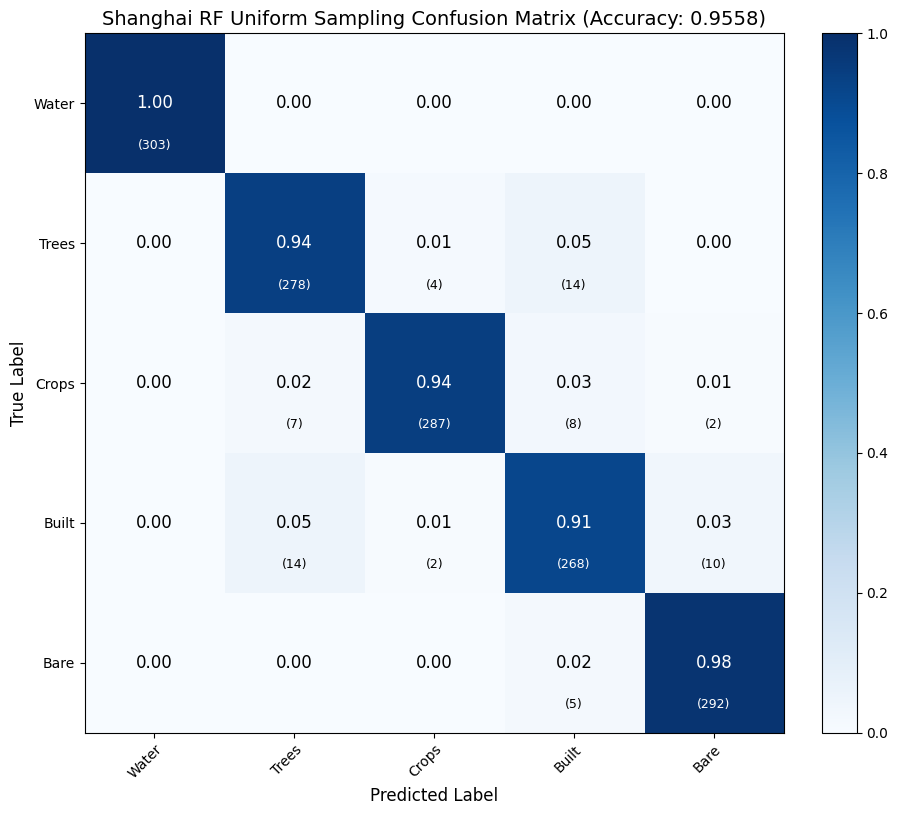

In [20]:
validation = val_data.classify(classifier)
confusion_matrix = validation.errorMatrix('class', 'classification')

def plot_ee_confusion_matrix(confusion_matrix, class_names=None):
    cm_array = np.array(confusion_matrix.array().getInfo())
    accuracy = confusion_matrix.accuracy().getInfo()
    if class_names is None:
        n_classes = cm_array.shape[0]
        class_names = [str(i) for i in range(n_classes)]
    cm_normalized = np.zeros(cm_array.shape)
    for i in range(cm_array.shape[0]):
        row_sum = np.sum(cm_array[i, :])
        if row_sum > 0:
            cm_normalized[i, :] = cm_array[i, :] / row_sum
    
    fig, ax = plt.subplots(figsize=(10, 8))

    im = ax.imshow(cm_normalized, interpolation='nearest', cmap='Blues', vmin=0, vmax=1)
    
    ax.set_title(f'Shanghai RF Uniform Sampling Confusion Matrix (Accuracy: {accuracy:.4f})', fontsize=14)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)
   
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            # Show normalized value
            ax.text(j, i, f"{cm_normalized[i, j]:.2f}",
                    ha="center", va="center",
                    color="white" if cm_normalized[i, j] > 0.5 else "black",
                    fontsize=12)
            
            # Show raw sample count in parentheses
            if cm_array[i, j] > 0:
                ax.text(j, i + 0.3, f"({int(cm_array[i, j])})",
                        ha="center", va="center",
                        color="white" if cm_normalized[i, j] > 0.5 else "black",
                        fontsize=9)
    
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    return fig, ax


class_names = ['Water', 'Trees', 'Crops', 'Built', 'Bare']

fig, ax = plot_ee_confusion_matrix(confusion_matrix, class_names)

plt.show()

In [45]:
def compute_accuracies(conf_matrix):
    cm = np.array(conf_matrix.array().getInfo())
    
    # 总样本数
    total = cm.sum()
    
    # 真实类总数（按行）
    actual = cm.sum(axis=1)
    
    # 预测类总数（按列）
    predicted = cm.sum(axis=0)
    
    # 准确分类数（对角线）
    correct = np.diag(cm)
    
    # Producer's Accuracy = 正确分类数 / 实际该类总数
    PA = correct / actual

    # User's Accuracy = 正确分类数 / 被预测为该类总数
    UA = correct / predicted

    # Overall Accuracy
    OA = correct.sum() / total
    
    # Kappa Coefficient
    expected = np.dot(actual, predicted) / (total ** 2)
    kappa = (OA - expected) / (1 - expected)

    return PA, UA, OA, kappa

# 计算 PA, UA, OA, Kappa
PA, UA, OA, kappa = compute_accuracies(confusion_matrix)

# 打印结果
print("📊 Accuracy Report")
print("Class\t\tPA\t\tUA")
for i, class_name in enumerate(class_names):
    print(f"{class_name:<10}\t{PA[i]:.4f}\t\t{UA[i]:.4f}")

print(f"\n✅ Overall Accuracy: {OA:.4f}")
print(f"✅ Kappa Coefficient: {kappa:.4f}")


📊 Accuracy Report
Class		PA		UA
Water     	1.0000		1.0000
Trees     	0.9010		0.9613
Crops     	0.9619		0.9329
Built     	0.8990		0.8866
Bare      	0.9779		0.9598

✅ Overall Accuracy: 0.9492
✅ Kappa Coefficient: 0.9365


In [21]:
# Your existing validation code
validation = val_data.classify(classifier)
confusion_matrix = validation.errorMatrix('class', 'classification')

def calculate_accuracy_metrics(confusion_matrix, class_names=None):
    """
    Calculate PA, UA, and Kappa from Google Earth Engine confusion matrix
    """
    # Get confusion matrix as array
    cm_array = np.array(confusion_matrix.array().getInfo())
    
    if class_names is None:
        n_classes = cm_array.shape[0]
        class_names = [f'Class_{i}' for i in range(n_classes)]
    
    n_classes = len(class_names)
    total_samples = np.sum(cm_array)
    diagonal_sum = np.sum(np.diag(cm_array))
    
    # Overall Accuracy
    overall_accuracy = diagonal_sum / total_samples
    
    # Producer's Accuracy (PA)
    producer_accuracy = {}
    for i in range(n_classes):
        true_positives = cm_array[i, i]
        column_sum = np.sum(cm_array[:, i])  # Reference total
        if column_sum > 0:
            producer_accuracy[class_names[i]] = true_positives / column_sum
        else:
            producer_accuracy[class_names[i]] = 0
    
    # User's Accuracy (UA)
    user_accuracy = {}
    for i in range(n_classes):
        true_positives = cm_array[i, i]
        row_sum = np.sum(cm_array[i, :])  # Classified total
        if row_sum > 0:
            user_accuracy[class_names[i]] = true_positives / row_sum
        else:
            user_accuracy[class_names[i]] = 0
    
    # Kappa Coefficient
    row_totals = np.sum(cm_array, axis=1)
    col_totals = np.sum(cm_array, axis=0)
    expected_accuracy = np.sum(row_totals * col_totals) / (total_samples ** 2)
    
    if (1 - expected_accuracy) != 0:
        kappa = (overall_accuracy - expected_accuracy) / (1 - expected_accuracy)
    else:
        kappa = 0
    
    return {
        'confusion_matrix': cm_array,
        'producer_accuracy': producer_accuracy,
        'user_accuracy': user_accuracy,
        'kappa_coefficient': kappa,
        'class_names': class_names
    }

def print_accuracy_results(confusion_matrix, class_names=None):
    """
    Print PA, UA, Confusion Matrix, and Kappa
    """
    metrics = calculate_accuracy_metrics(confusion_matrix, class_names)
    
    print("="*50)
    print("ACCURACY ASSESSMENT RESULTS")
    print("="*50)
    
    # Confusion Matrix
    print("\n📊 CONFUSION MATRIX:")
    cm_array = metrics['confusion_matrix']
    class_names = metrics['class_names']
    
    # Print header
    print(f"{'':>12}", end="")
    for name in class_names:
        print(f"{name:>8}", end="")
    print()
    
    # Print matrix rows
    for i, true_class in enumerate(class_names):
        print(f"{true_class:>12}", end="")
        for j in range(len(class_names)):
            print(f"{int(cm_array[i, j]):>8}", end="")
        print()
    
    # Producer's Accuracy
    print(f"\n🎯 PRODUCER'S ACCURACY (PA):")
    print("-" * 30)
    for class_name, pa in metrics['producer_accuracy'].items():
        print(f"{class_name:>10}: {pa:.4f} ({pa*100:.2f}%)")
    
    # User's Accuracy
    print(f"\n🎯 USER'S ACCURACY (UA):")
    print("-" * 30)
    for class_name, ua in metrics['user_accuracy'].items():
        print(f"{class_name:>10}: {ua:.4f} ({ua*100:.2f}%)")
    
    # Kappa Coefficient
    print(f"\n📊 KAPPA COEFFICIENT: {metrics['kappa_coefficient']:.4f}")
    
    print("="*50)

# Usage with your data
class_names = ['Water', 'Trees', 'Crops', 'Built', 'Bare']

# Print results
print_accuracy_results(confusion_matrix, class_names)

ACCURACY ASSESSMENT RESULTS

📊 CONFUSION MATRIX:
               Water   Trees   Crops   Built    Bare
       Water     303       0       0       0       0
       Trees       0     278       4      14       0
       Crops       0       7     287       8       2
       Built       0      14       2     268      10
        Bare       0       0       0       5     292

🎯 PRODUCER'S ACCURACY (PA):
------------------------------
     Water: 1.0000 (100.00%)
     Trees: 0.9298 (92.98%)
     Crops: 0.9795 (97.95%)
     Built: 0.9085 (90.85%)
      Bare: 0.9605 (96.05%)

🎯 USER'S ACCURACY (UA):
------------------------------
     Water: 1.0000 (100.00%)
     Trees: 0.9392 (93.92%)
     Crops: 0.9441 (94.41%)
     Built: 0.9116 (91.16%)
      Bare: 0.9832 (98.32%)

📊 KAPPA COEFFICIENT: 0.9448


DETAILED CLASSIFICATION METRICS REPORT

OVERALL METRICS:
Overall Accuracy: 0.9558 (95.58%)
Kappa Coefficient: 0.9448
Kappa Interpretation: (Excellent agreement)

CLASS-WISE METRICS:
--------------------------------------------------------------------------------
Class      Producer Acc User Acc     F1-Score     Samples   
--------------------------------------------------------------------------------
Water      1.0000       1.0000       1.0000       303       
Trees      0.9298       0.9392       0.9345       296       
Crops      0.9795       0.9441       0.9615       304       
Built      0.9085       0.9116       0.9100       294       
Bare       0.9605       0.9832       0.9717       297       
--------------------------------------------------------------------------------
Average    0.9557       0.9556       0.9555       1494      


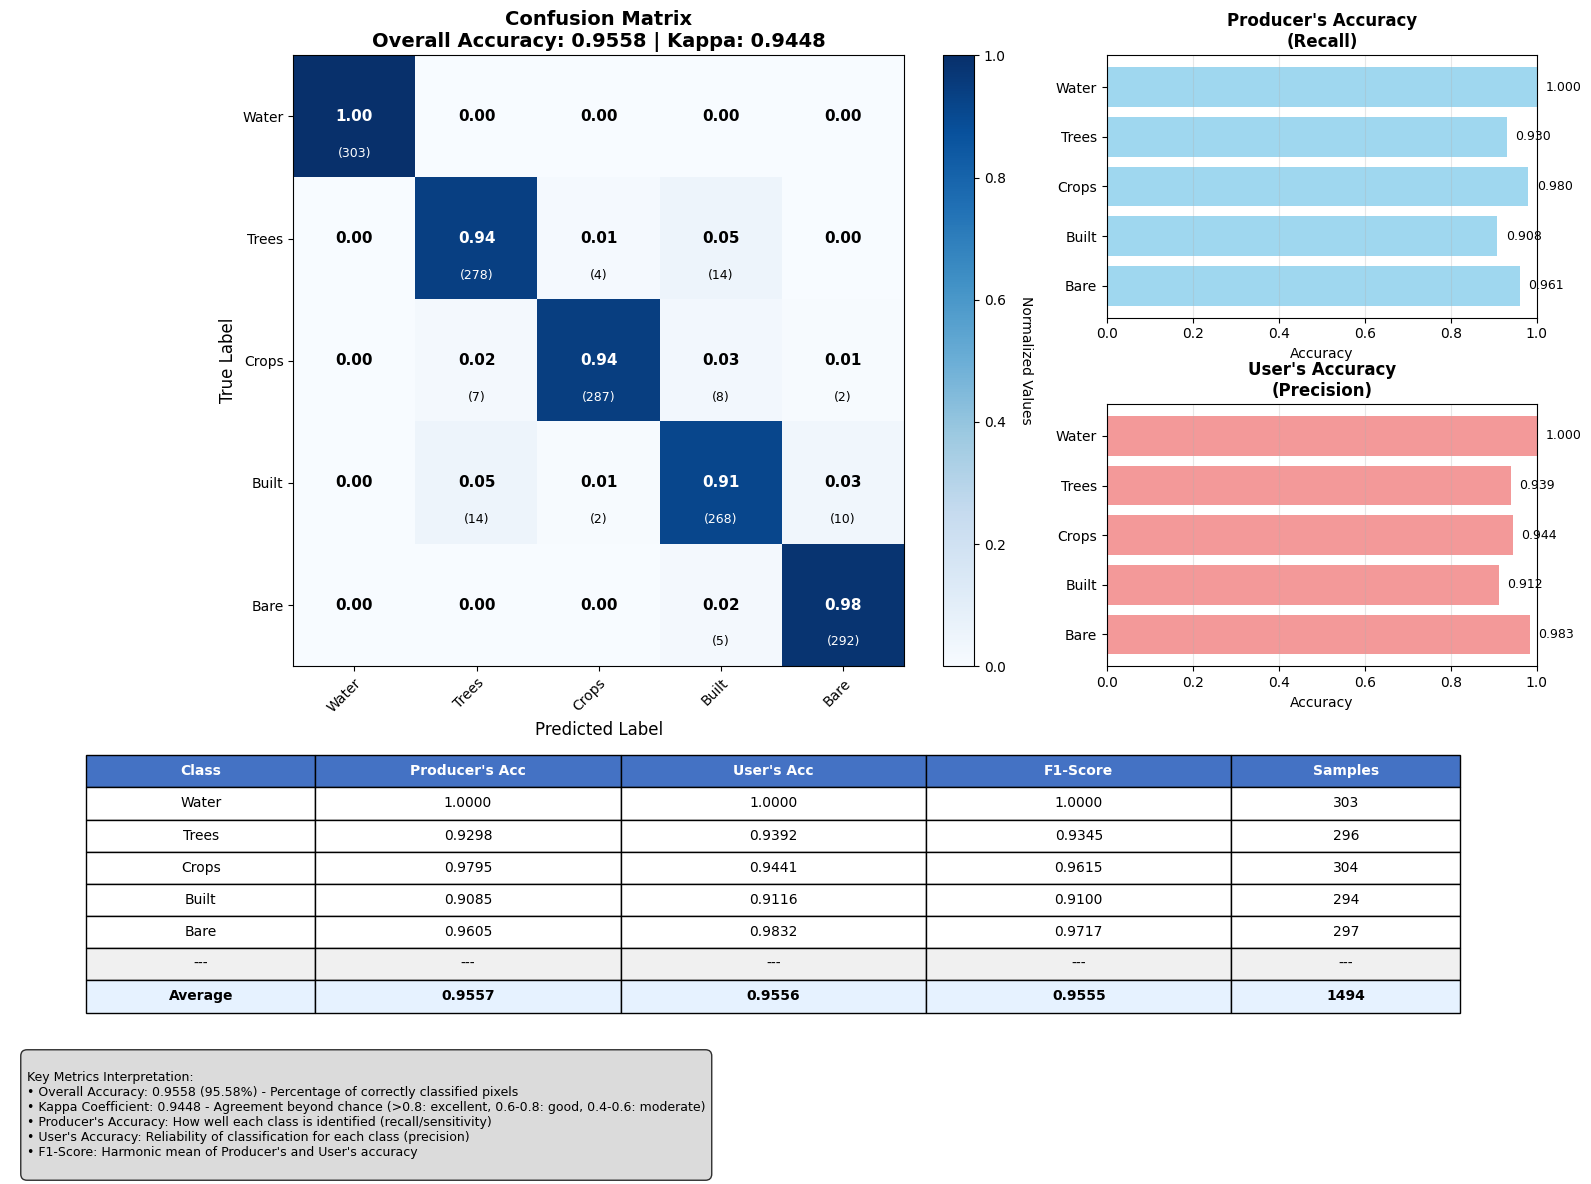

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import cohen_kappa_score

# Your existing validation and confusion matrix code
validation = val_data.classify(classifier)
confusion_matrix = validation.errorMatrix('class', 'classification')

def calculate_accuracy_metrics(cm_array):
    """Calculate comprehensive accuracy metrics from confusion matrix"""
    n_classes = cm_array.shape[0]
    
    # Calculate Producer's Accuracy (PA) - also known as Recall or Sensitivity
    producer_accuracy = np.zeros(n_classes)
    for i in range(n_classes):
        col_sum = np.sum(cm_array[:, i])  # True positives + False negatives
        if col_sum > 0:
            producer_accuracy[i] = cm_array[i, i] / col_sum
    
    # Calculate User's Accuracy (UA) - also known as Precision
    user_accuracy = np.zeros(n_classes)
    for i in range(n_classes):
        row_sum = np.sum(cm_array[i, :])  # True positives + False positives
        if row_sum > 0:
            user_accuracy[i] = cm_array[i, i] / row_sum
    
    # Calculate Overall Accuracy
    total_correct = np.trace(cm_array)  # Sum of diagonal elements
    total_samples = np.sum(cm_array)
    overall_accuracy = total_correct / total_samples if total_samples > 0 else 0
    
    # Calculate Kappa Coefficient
    # Observed accuracy
    po = overall_accuracy
    
    # Expected accuracy by chance
    marginal_rows = np.sum(cm_array, axis=1)
    marginal_cols = np.sum(cm_array, axis=0)
    pe = np.sum(marginal_rows * marginal_cols) / (total_samples ** 2)
    
    # Kappa coefficient
    kappa = (po - pe) / (1 - pe) if (1 - pe) != 0 else 0
    
    return producer_accuracy, user_accuracy, overall_accuracy, kappa

def plot_enhanced_confusion_matrix(confusion_matrix, class_names=None):
    """Enhanced confusion matrix with comprehensive metrics"""
    cm_array = np.array(confusion_matrix.array().getInfo())
    
    if class_names is None:
        n_classes = cm_array.shape[0]
        class_names = [str(i) for i in range(n_classes)]
    
    # Calculate all metrics
    pa, ua, overall_acc, kappa = calculate_accuracy_metrics(cm_array)
    
    # Normalize confusion matrix for visualization
    cm_normalized = np.zeros(cm_array.shape)
    for i in range(cm_array.shape[0]):
        row_sum = np.sum(cm_array[i, :])
        if row_sum > 0:
            cm_normalized[i, :] = cm_array[i, :] / row_sum
    
    # Create figure with subplots
    fig = plt.figure(figsize=(16, 12))
    
    # Main confusion matrix plot
    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2, rowspan=2)
    
    im = ax1.imshow(cm_normalized, interpolation='nearest', cmap='Blues', vmin=0, vmax=1)
    
    ax1.set_title(f'Confusion Matrix\nOverall Accuracy: {overall_acc:.4f} | Kappa: {kappa:.4f}', 
                  fontsize=14, fontweight='bold')
    ax1.set_ylabel('True Label', fontsize=12)
    ax1.set_xlabel('Predicted Label', fontsize=12)
    
    ax1.set_xticks(np.arange(len(class_names)))
    ax1.set_yticks(np.arange(len(class_names)))
    ax1.set_xticklabels(class_names)
    ax1.set_yticklabels(class_names)
    
    # Add text annotations to confusion matrix
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            # Show normalized value
            ax1.text(j, i, f"{cm_normalized[i, j]:.2f}",
                    ha="center", va="center",
                    color="white" if cm_normalized[i, j] > 0.5 else "black",
                    fontsize=11, fontweight='bold')
            
            # Show raw sample count in parentheses
            if cm_array[i, j] > 0:
                ax1.text(j, i + 0.3, f"({int(cm_array[i, j])})",
                        ha="center", va="center",
                        color="white" if cm_normalized[i, j] > 0.5 else "black",
                        fontsize=9)
    
    # Add colorbar
    cbar = ax1.figure.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    cbar.set_label('Normalized Values', rotation=270, labelpad=20)
    
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Producer's Accuracy bar chart - displayed from top to bottom (Water to Bare)
    ax2 = plt.subplot2grid((3, 3), (0, 2))
    # Reverse the order for plotting so Water appears at top
    y_positions = range(len(class_names))
    reversed_pa = pa[::-1]  # Reverse the PA values
    reversed_class_names = class_names[::-1]  # Reverse class names
    
    bars1 = ax2.barh(y_positions, reversed_pa, color='skyblue', alpha=0.8)
    ax2.set_title("Producer's Accuracy\n(Recall)", fontsize=12, fontweight='bold')
    ax2.set_xlabel('Accuracy')
    ax2.set_yticks(y_positions)
    ax2.set_yticklabels(reversed_class_names)
    ax2.set_xlim(0, 1)
    ax2.grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars1, reversed_pa)):
        ax2.text(val + 0.02, i, f'{val:.3f}', va='center', fontsize=9)
    
    # User's Accuracy bar chart - displayed from top to bottom (Water to Bare)
    ax3 = plt.subplot2grid((3, 3), (1, 2))
    reversed_ua = ua[::-1]  # Reverse the UA values
    
    bars2 = ax3.barh(y_positions, reversed_ua, color='lightcoral', alpha=0.8)
    ax3.set_title("User's Accuracy\n(Precision)", fontsize=12, fontweight='bold')
    ax3.set_xlabel('Accuracy')
    ax3.set_yticks(y_positions)
    ax3.set_yticklabels(reversed_class_names)
    ax3.set_xlim(0, 1)
    ax3.grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars2, reversed_ua)):
        ax3.text(val + 0.02, i, f'{val:.3f}', va='center', fontsize=9)
    
    # Metrics summary table
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
    ax4.axis('off')
    
    # Create metrics summary - maintain original order (Water to Bare)
    metrics_data = []
    for i, class_name in enumerate(class_names):
        metrics_data.append([
            class_name,
            f"{pa[i]:.4f}",
            f"{ua[i]:.4f}",
            f"{2 * pa[i] * ua[i] / (pa[i] + ua[i]) if (pa[i] + ua[i]) > 0 else 0:.4f}",  # F1-score
            f"{int(np.sum(cm_array[i, :]))}"  # Sample count
        ])
    
    # Add overall metrics
    avg_pa = np.mean(pa)
    avg_ua = np.mean(ua)
    macro_f1 = np.mean([2 * pa[i] * ua[i] / (pa[i] + ua[i]) if (pa[i] + ua[i]) > 0 else 0 
                       for i in range(len(pa))])
    
    metrics_data.append(['---', '---', '---', '---', '---'])
    metrics_data.append([
        'Average',
        f"{avg_pa:.4f}",
        f"{avg_ua:.4f}",
        f"{macro_f1:.4f}",
        f"{int(np.sum(cm_array))}"
    ])
    
    # Create table
    table = ax4.table(cellText=metrics_data,
                     colLabels=['Class', "Producer's Acc", "User's Acc", 'F1-Score', 'Samples'],
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.15, 0.2, 0.2, 0.2, 0.15])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Style the table
    for i in range(len(class_names) + 2):
        for j in range(5):
            cell = table[(i + 1, j)]
            if i == len(class_names):  # Separator row
                cell.set_facecolor('#f0f0f0')
            elif i == len(class_names) + 1:  # Average row
                cell.set_facecolor('#e6f2ff')
                cell.set_text_props(weight='bold')
            else:
                cell.set_facecolor('white')
    
    # Header styling
    for j in range(5):
        table[(0, j)].set_facecolor('#4472C4')
        table[(0, j)].set_text_props(weight='bold', color='white')
    
    # Add interpretation text
    interpretation_text = f"""
Key Metrics Interpretation:
• Overall Accuracy: {overall_acc:.4f} ({overall_acc*100:.2f}%) - Percentage of correctly classified pixels
• Kappa Coefficient: {kappa:.4f} - Agreement beyond chance (>0.8: excellent, 0.6-0.8: good, 0.4-0.6: moderate)
• Producer's Accuracy: How well each class is identified (recall/sensitivity)
• User's Accuracy: Reliability of classification for each class (precision)
• F1-Score: Harmonic mean of Producer's and User's accuracy
    """
    
    plt.figtext(0.02, 0.02, interpretation_text, fontsize=9, 
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    
    return fig, (ax1, ax2, ax3, ax4), (pa, ua, overall_acc, kappa)

def print_detailed_metrics(cm_array, class_names, pa, ua, overall_acc, kappa):
    """Print detailed metrics summary"""
    print("="*60)
    print("DETAILED CLASSIFICATION METRICS REPORT")
    print("="*60)
    
    print(f"\nOVERALL METRICS:")
    print(f"Overall Accuracy: {overall_acc:.4f} ({overall_acc*100:.2f}%)")
    print(f"Kappa Coefficient: {kappa:.4f}")
    
    kappa_interpretation = ""
    if kappa > 0.8:
        kappa_interpretation = "(Excellent agreement)"
    elif kappa > 0.6:
        kappa_interpretation = "(Good agreement)"
    elif kappa > 0.4:
        kappa_interpretation = "(Moderate agreement)"
    elif kappa > 0.2:
        kappa_interpretation = "(Fair agreement)"
    else:
        kappa_interpretation = "(Poor agreement)"
    
    print(f"Kappa Interpretation: {kappa_interpretation}")
    
    print(f"\nCLASS-WISE METRICS:")
    print("-" * 80)
    print(f"{'Class':<10} {'Producer Acc':<12} {'User Acc':<12} {'F1-Score':<12} {'Samples':<10}")
    print("-" * 80)
    
    for i, class_name in enumerate(class_names):
        f1 = 2 * pa[i] * ua[i] / (pa[i] + ua[i]) if (pa[i] + ua[i]) > 0 else 0
        samples = int(np.sum(cm_array[i, :]))
        print(f"{class_name:<10} {pa[i]:<12.4f} {ua[i]:<12.4f} {f1:<12.4f} {samples:<10}")
    
    print("-" * 80)
    avg_pa = np.mean(pa)
    avg_ua = np.mean(ua)
    macro_f1 = np.mean([2 * pa[i] * ua[i] / (pa[i] + ua[i]) if (pa[i] + ua[i]) > 0 else 0 
                       for i in range(len(pa))])
    total_samples = int(np.sum(cm_array))
    
    print(f"{'Average':<10} {avg_pa:<12.4f} {avg_ua:<12.4f} {macro_f1:<12.4f} {total_samples:<10}")
    print("="*60)

# Usage with your data
class_names = ['Water', 'Trees', 'Crops', 'Built', 'Bare']

# Create the enhanced visualization
fig, axes, metrics = plot_enhanced_confusion_matrix(confusion_matrix, class_names)

# Extract metrics for detailed printing
cm_array = np.array(confusion_matrix.array().getInfo())
pa, ua, overall_acc, kappa = metrics

# Print detailed metrics
print_detailed_metrics(cm_array, class_names, pa, ua, overall_acc, kappa)

plt.show()